In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
import healpy as hp

In [4]:
from astropy.io import fits

In [5]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [6]:
from __future__ import unicode_literals

figsize(10,8)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [7]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [8]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [9]:
c = coordinates.SkyCoord(frame='galactic', l=107.2*u.degree, b=5.2*u.degree)

In [10]:
c.icrs.ra.deg

335.7133441444117

In [11]:
c.icrs.dec.deg

63.43802542905474

In [12]:
def calculate_sflux_gal(bank='A', session='5', doplot=True, pixbeam=1., smth=0, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    #rc = 335.7133441444117
    #dc = 63.43802542905474
    
    c = coordinates.SkyCoord(frame='icrs', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    rc = 107.2
    dc = 5.2
    
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if removeplane:
        rabinsc = (rabins[1:] + rabins[:-1]) / 2.
        decbinsc = (decbins[1:] + decbins[:-1]) / 2.
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    if smth is None:
        smth = beam
    if smth > 0:
        signal = gaussian_filter(signal, smth/pixbeam)
        shits = gaussian_filter(hits, smth/pixbeam)
        mask = shits < 1
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
        clim(-15, 15)
        cb = colorbar()
        xlabel('$\mathrm{Lon}\ (deg)$')
        ylabel('$\mathrm{Lat}\ (deg)$')
        cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
        #savefig('s4map_bank'+bank+'session'+session)
    
    print np.nansum(signal[innerregion])
    return rabinsc, decbinsc, signal

34.1295179476


/usr/lib64/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


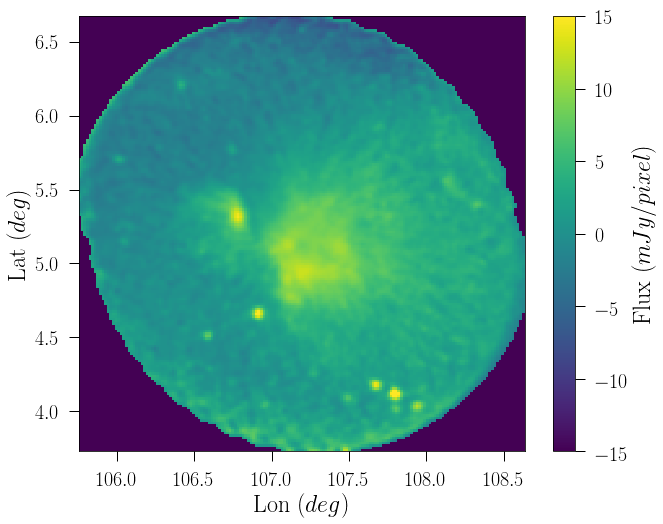

In [13]:
rabinsc, decbinsc, signal = calculate_sflux_gal('A', '5', smth=1.)

In [14]:
rabinsc, decbinsc, signal = calculate_sflux_gal('A', '5', smth=None, doplot=False)

34.0901809149


In [15]:
rabinsc[0]

105.75373014758679

In [16]:
rabinsc[-1]

108.63985470200107

In [17]:
decbinsc[0]

3.7308093328743528

In [18]:
decbinsc[-1]

6.6709293227336524

In [19]:
gridx, gridy = np.meshgrid(rabinsc, decbinsc)

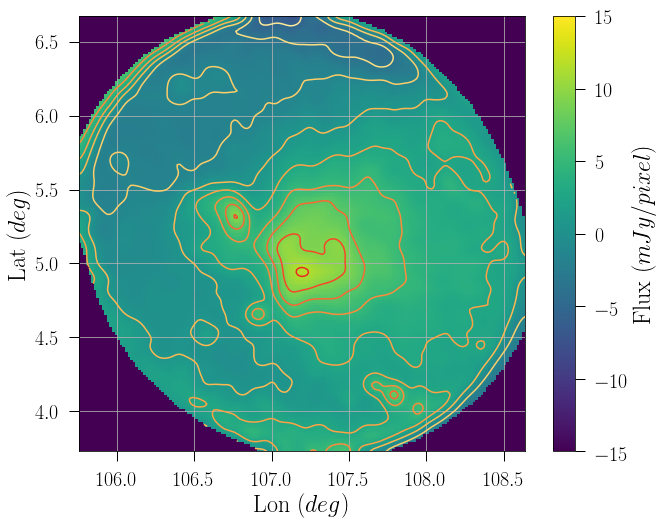

In [20]:
pcolormesh(rabinsc, decbinsc, signal*1000)
clim(-15, 15)
cb = colorbar()
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid()
#savefig('s4contour_mapoverlay_A5')

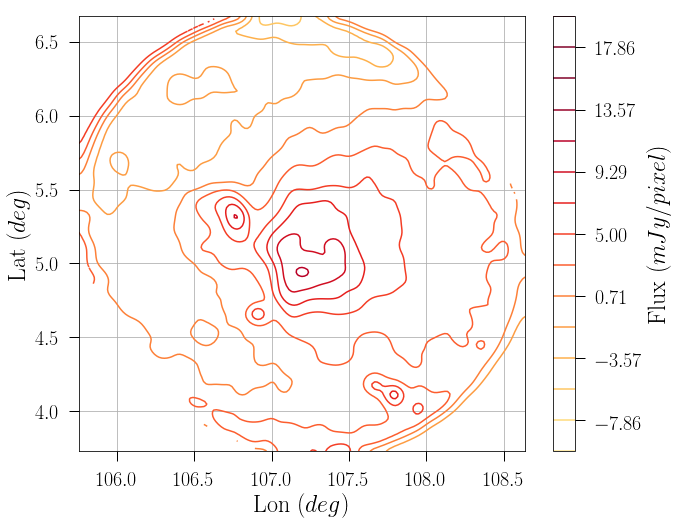

In [21]:
figure()
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
clim(-15, 15)
cb = colorbar()
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid()
#savefig('s4contour_A5')

In [22]:
xmap = fits.open('../externaldata/new-image.fits')
hdu = xmap[0]
cra = hdu.header['CRVAL1']
mra = hdu.header['CRPIX1']
cdec = hdu.header['CRVAL2']
mdec = hdu.header['CRPIX2']
spix = hdu.header['CD1_1']
ras = (np.arange(1663) - mra) * spix + cra
decs = (np.arange(1252) - mdec) * spix + cdec

In [23]:
ras = (np.arange(1663) - 1663/2.) * 4.2/60./60. + 335.35

In [24]:
decs = (np.arange(1252) - 1252/2.) * 4.2/60./60. + 63.433333333333

In [25]:
mra

1014.30889966

In [26]:
cra

335.818800184

In [27]:
(22. + 21.4/60) / 24. * 360.

335.34999999999997

In [28]:
cra - 335.35

0.46880018399997425

In [29]:
cdec

63.4196299498

In [30]:
63 + 26./60

63.43333333333333

In [31]:
spix * 60 * 60

4.195820058300001

In [32]:
RA 22h 21.4m, Dec +63° 26’, PA +180° 29’

SyntaxError: invalid syntax (<ipython-input-32-fb8487cf6425>, line 1)

In [33]:
: 1° 56’ x 1° 28’

SyntaxError: invalid syntax (<ipython-input-33-aa74d4dce0f7>, line 1)

In [34]:
e: 4.2” / pixel

SyntaxError: invalid syntax (<ipython-input-34-d5562998a52b>, line 1)

In [35]:
ras

array([ 334.37991667,  334.38108333,  334.38225   , ...,  336.31658333,
        336.31775   ,  336.31891667])

In [36]:
decs

array([ 62.703     ,  62.70416667,  62.70533333, ...,  64.16016667,
        64.16133333,  64.1625    ])

In [37]:
ras2 = ras - 0.668
decs2 = decs + 0

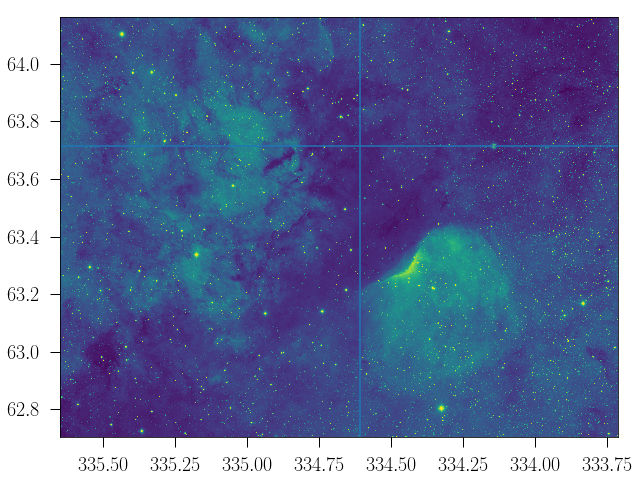

In [70]:
imshow(hdu.data[:, ::-1], extent=(ras2[-1], ras2[0], decs[0], decs[-1]), origin='lower')
ax = gca()
ax.axvline(334.6102916666667)
ax.axhline(63.716)

In [39]:
43/60.

0.7166666666666667

In [81]:
ras -= 0.4

In [82]:
rgrid, dgrid = np.meshgrid(ras, decs)

In [83]:
rrs = rgrid.flatten()
dds = dgrid.flatten()

In [84]:
xs = hdu.data.flatten()

In [85]:
c = coordinates.SkyCoord(frame='icrs', ra=rrs*u.degree, dec=dds*u.degree)

In [86]:
lats = c.galactic.b.deg
lons = c.galactic.l.deg

In [87]:
nrapix = int((lons.max() - lons.min()) / (4.2 / 3600.))
ndecpix = int((lats.max() - lats.min()) / (4.2 / 3600.))

datamap, hits, lonbins, latbins = naive_map(xs, lons, lats, nrapix, ndecpix) 
mask = hits == 0
xsig = np.zeros_like(datamap)
xsig[~mask] = datamap[~mask] / hits[~mask]
xsig[mask] = np.nan

In [88]:
maskx = (gridx[0, :] > lonbins[0]) * (gridx[0, :] < lonbins[-1])

In [89]:
masky = (gridy[:, 0] > latbins[0]) * (gridy[:, 0] < latbins[-1])

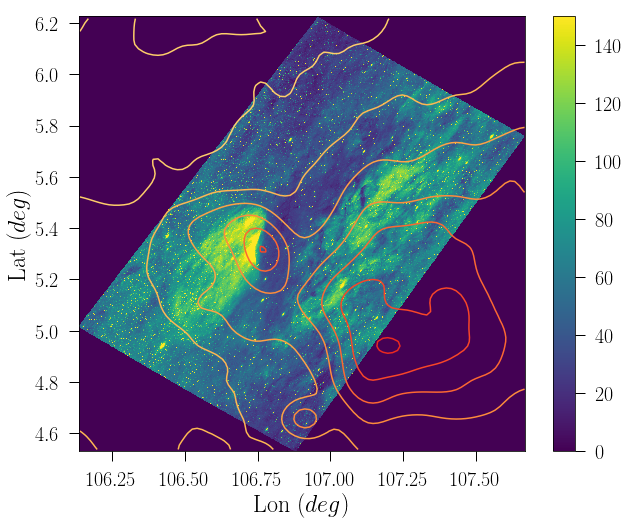

In [90]:
pcolormesh(lonbins, latbins, xsig)
clim(0, 150)
colorbar();
contour(gridx[masky, :][:, maskx], gridy[masky, :][:, maskx], signal[masky, :][:, maskx]*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
#savefig('highres_halpha_contour_gal')

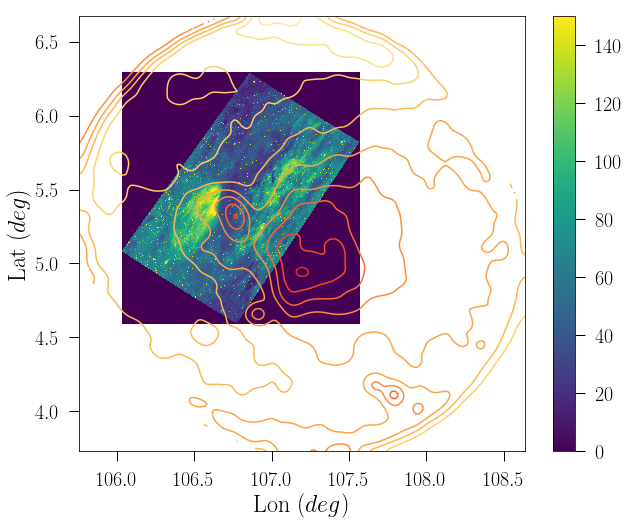

In [52]:
pcolormesh(lonbins, latbins, xsig)
clim(0, 150)
colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
#savefig('highres_halpha_contour')

In [87]:
xmap = fits.open('../externaldata/PTF-Image.fits')

In [91]:
hdu = xmap[0]

In [92]:
hdu.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / FOUR-BYTE SINGLE PRECISION FLOATING POINT      
NAXIS   =                    2 / STANDARD FITS FORMAT                           
NAXIS1  =                 2048 / STANDARD FITS FORMAT                           
NAXIS2  =                 4096 / STANDARD FITS FORMAT                           
ORIGIN  = 'Palomar Transient Factory' / Origin of these image data              
CREATOR = 'Infrared Processing and Analysis Center' / Creator of this FITS file 
TELESCOP= 'P48     '           / Name of telescope                              
INSTRUME= 'PTF/MOSAIC'         / Instrument name                                
OBSERVER= 'KulkarniPTF'        / Observer name and project                      
CCDID   = '10      '           / CCD number (0..11)                             
DATE-OBS= '2013-06-19T11:28:32.854' / UTC shutter time YYYY-MM-DDTHH:MM:SS.SSS  
DATE    = '2013-06-19T04:50:

In [95]:
ptfmap = hdu.data

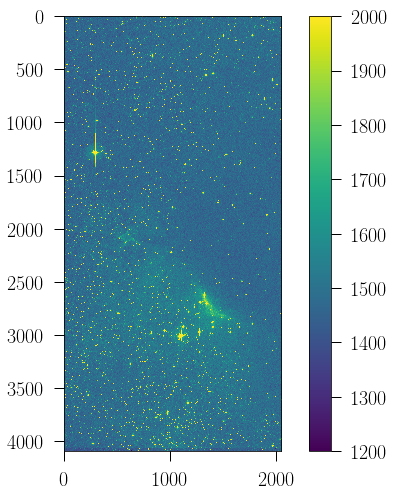

In [106]:
imshow(ptfmap)
colorbar()
clim(1200, 2000)

In [75]:
xmap = fits.open('../externaldata/r373070-3.fits.fz')

In [79]:
hdu = xmap[1]

In [80]:
hdu.header

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   16 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 2048 / length of original image axis                  
NAXIS2  =                 4096 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
RUN     =               373070 / Run number                                     
OBSERVAT= 'LAPALMA '           / Name of observatory (IRAF style)               
OBSERVER= 'Drew    '           / Name of principal investigator                 
OBJECT  = 'intphas_7008o Ha'   / Title of observation                           
LATITUDE=            28.761978 / Telescope latitude  (degrees), +28:45:43.1     
LONGITUD=           -17.8776

In [81]:
iphas = hdu.data

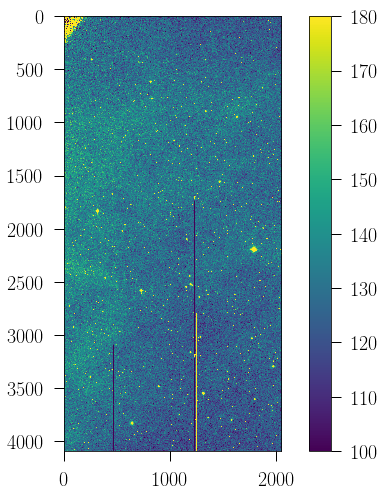

In [108]:
imshow(iphas)
colorbar()
clim(100, 180)

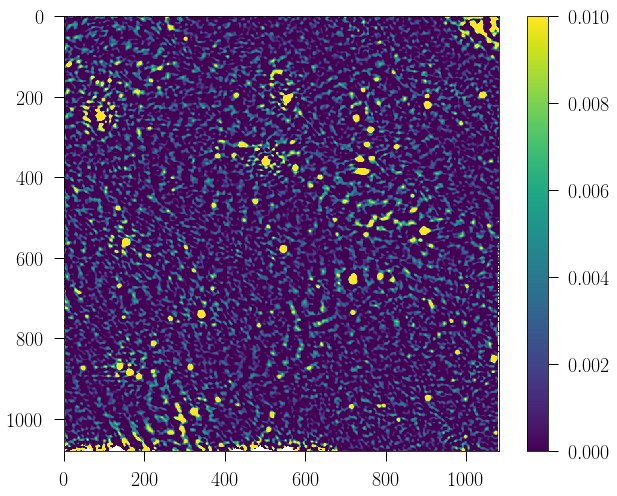

In [51]:
imshow(amimap)
colorbar()
clim(0, 0.01)

In [ ]:
xmap = fits.open('../externaldata/new-image.fits')
hdu = xmap[0]
cra = hdu.header['CRVAL1']
mra = hdu.header['CRPIX1']
cdec = hdu.header['CRVAL2']
mdec = hdu.header['CRPIX2']
spix = hdu.header['CD1_1']
ras = (np.arange(1663) - mra) * spix + cra
decs = (np.arange(1252) - mdec) * spix + cdec